# Dependencies and paths to datasets

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from transformers import pipeline

yt_path = "../data/youtube_sentiment.csv"
gd_path = "../data/gdelt_sentiment.csv"

# Read YouTube and GDELT datasets

In [2]:
yt = pd.read_csv(yt_path)
gd = pd.read_csv(gd_path)

# Load BERTopic model and perform it on YouTube dataset for initial topic modelling

In [4]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

topic_model_yt = BERTopic(
    embedding_model=embedding_model,
    language="english",
    calculate_probabilities=True,
    verbose=True,
)

yt_topics, yt_probs = topic_model_yt.fit_transform(
    yt["clean_comment_text"].tolist()
)

yt["topic_id"] = yt_topics

topic_model_yt.get_topic_info()

2025-12-11 15:09:20,613 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 2764/2764 [05:31<00:00,  8.35it/s]  
2025-12-11 15:14:52,887 - BERTopic - Embedding - Completed ✓
2025-12-11 15:14:52,887 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-11 15:15:23,526 - BERTopic - Dimensionality - Completed ✓
2025-12-11 15:15:23,527 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenize

,Topic,Count,Name,Representation,Representative_Docs
0,-1,37297,-1_ai_will_and_to,"[ai, will, and, to, we, of, that, people, are,...",[the whole argument of not anthropomorphizing ...
1,0,8201,0_robots_ai_generative_jobs,"[robots, ai, generative, jobs, robot, will, re...",[not all companies will be able to afford robo...
2,1,2810,1_gpt_chat_chatgpt_gpt4,"[gpt, chat, chatgpt, gpt4, 4o, gpt5, document,...","[chat gpt who, chat gpt is that you, that is n..."
3,2,1455,2_tye_hai_bhai_ka,"[tye, hai, bhai, ka, bu, kya, bhi, ko, mayer, ...","[hindi me nahi hai kya, free nahi hai paid hai..."
4,3,975,3_llm_llms_understand_model,"[llm, llms, understand, model, training, data,...",[llms are (maybe) better in understanding the ...
...,...,...,...,...,...
716,715,10,715_comments_generated_diffused_favorable,"[comments, generated, diffused, favorable, han...","[are all of these comments ai? 🤣, all these co..."
717,716,10,716_watermarks_server_facebook_host,"[watermarks, server, facebook, host, creator, ...",[i have a feeling that content credentials is ...
718,717,10,717_rent_apartments_wont_hertz,"[rent, apartments, wont, hertz, closet, rentin...","[usa is rent free in these comments, just don'..."
719,718,10,718_facts_juuuust_prolly_spitting,"[facts, juuuust, prolly, spitting, stating, dr...","[you sir speak facts, nothing but facts 😂😂😂😂😂😂..."


# We want to match each topic to a macro category from a list: ai_general, economic_implications, social implications and others. Firstly, we'll classify them into ai or not.

In [35]:
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

labels_ai_presence = [
    "This topic is about artificial intelligence, generative AI, ChatGPT, GPT models, AI technology",
    "This topic is not related to artificial intelligence or its impacts and is about something else"
]

data_topics = set(yt["topic_id"].unique())
topic_to_macro = {}

topic_texts = {}
for topic_id in data_topics:
    words_scores = topic_model_yt.get_topic(topic_id)
    if not words_scores:
        if topic_id == -1:
            topic_texts[topic_id] = "outlier noise comments unrelated to any clear topic"
        else:
            topic_texts[topic_id] = "rare topic with few comments and unclear meaning"
    else:
        top_words = [w for w, _ in words_scores[:10]]
        topic_texts[topic_id] = " ".join(top_words)

for topic_id, topic_text in topic_texts.items():
    r = classifier(topic_text, labels_ai_presence)
    best = r["labels"][0]
    if "not related" in best:
        topic_to_macro[topic_id] = "Other"
    else:
        topic_to_macro[topic_id] = None   # mark as AI-related for step 2


Device set to use mps:0


# After we classified all topics into ai and not ai, we classify further in ai_general, economic_implications and social implications

In [36]:
labels_ai_type = [
    "General technical discussion of artificial intelligence, generative AI, ChatGPT, GPT models, AI technology",
    "Social implications of AI such as ethics, bias, trust, misinformation, culture, education, human relationships, society and people",
    "Economic implications of AI such as jobs, unemployment, layoffs, automation, wages, salary, the economy, business, companies, productivity"
]

for topic_id, topic_text in topic_texts.items():
    # skip topics already labelled "other"
    if topic_to_macro[topic_id] == "Other":
        continue

    r = classifier(topic_text, labels_ai_type)
    best = r["labels"][0]

    if best.startswith("General technical discussion"):
        topic_to_macro[topic_id] = "ai_general"
    elif best.startswith("Social implications"):
        topic_to_macro[topic_id] = "social_implications"
    else:
        topic_to_macro[topic_id] = "economic_implications"

yt["macro_category"] = yt["topic_id"].map(topic_to_macro)
yt["macro_category"].value_counts()

macro_category
ai_general               53091
Other                    31226
social_implications       3211
economic_implications      908
Name: count, dtype: int64

# Perform BERTopic model on GDELT dataset

In [37]:
topic_model_gd = BERTopic(
    embedding_model=embedding_model,
    language="english",
    calculate_probabilities=True,
    verbose=True,
)

gd_topics, gd_probs = topic_model_gd.fit_transform(
    gd["clean_title"].tolist()
)

gd["topic_id"] = gd_topics
topic_model_gd.get_topic_info()

2025-12-12 14:20:08,528 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1664/1664 [00:42<00:00, 39.45it/s]
2025-12-12 14:20:51,045 - BERTopic - Embedding - Completed ✓
2025-12-12 14:20:51,045 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-12 14:21:04,391 - BERTopic - Dimensionality - Completed ✓
2025-12-12 14:21:04,393 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-12 15:43:41,821 - BERTopic - Cluster - Completed ✓
2025-12-12 15:43:41,844 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-12-12 15:43:42,568 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,19517,-1_and_to_the_ai,"[and, to, the, ai, digital, of, with, for, on,...",[94 % of business leaders are using generative...
1,0,1167,0_jobs_job_workers_workforce,"[jobs, job, workers, workforce, workplace, edg...",[the double - edged sword of ai in the workfor...
2,1,882,1_chatbots_chatbot_chatgpt_like,"[chatbots, chatbot, chatgpt, like, bot, you, t...","[chatgpt , a new wave of chatbots, 10 best ai ..."
3,2,584,2_india_indian_hindu_businessline,"[india, indian, hindu, businessline, trak, rs,...",[158 % increase in ai - jobs across india ! th...
4,3,475,3_raises_funding_seed_series,"[raises, funding, seed, series, million, round...",[generative ai startup rephrase . ai raises $1...
...,...,...,...,...,...
653,652,10,652_broadcom_chip_gpu_shortages,"[broadcom, chip, gpu, shortages, developing, n...","[openai might be building its own chip , but i..."
654,653,10,653_writing_axio_brevity_turnitin,"[writing, axio, brevity, turnitin, flawless, c...",[ai detection and paraphrasing : the one - sto...
655,654,10,654_course_bundle_edureka_learn,"[course, bundle, edureka, learn, master, heck,...",[learn how to use chatgpt with this $10 course...
656,655,10,655_fertility_father_prelude_marcom,"[fertility, father, prelude, marcom, surrogate...",[the download : how fertility tech is changing...


# Topic classification for GDELT dataset

In [38]:
labels_ai_presence = [
    "This topic is about artificial intelligence, generative AI, ChatGPT, GPT models, AI technology",
    "This topic is not related to artificial intelligence or its impacts and is about something else"
]

data_topics = set(gd["topic_id"].unique())
topic_to_macro = {}

topic_texts = {}
for topic_id in data_topics:
    words_scores = topic_model_gd.get_topic(topic_id)
    if not words_scores:
        if topic_id == -1:
            topic_texts[topic_id] = "outlier noise comments unrelated to any clear topic"
        else:
            topic_texts[topic_id] = "rare topic with few comments and unclear meaning"
    else:
        top_words = [w for w, _ in words_scores[:10]]
        topic_texts[topic_id] = " ".join(top_words)

for topic_id, topic_text in topic_texts.items():
    r = classifier(topic_text, labels_ai_presence)
    best = r["labels"][0]
    if "not related" in best:
        topic_to_macro[topic_id] = "Other"
    else:
        topic_to_macro[topic_id] = None   # mark as AI-related for step 2


# Topic classification for GDELT dataset

In [39]:
labels_ai_type = [
    "General technical discussion of artificial intelligence, generative AI, ChatGPT, GPT models, AI technology",
    "Social implications of AI such as ethics, bias, trust, misinformation, culture, education, human relationships, society and people",
    "Economic implications of AI such as jobs, unemployment, layoffs, automation, wages, salary, the economy, business, companies, productivity"
]

for topic_id, topic_text in topic_texts.items():
    # skip topics already labelled "other"
    if topic_to_macro[topic_id] == "Other":
        continue

    r = classifier(topic_text, labels_ai_type)
    best = r["labels"][0]

    if best.startswith("General technical discussion"):
        topic_to_macro[topic_id] = "ai_general"
    elif best.startswith("Social implications"):
        topic_to_macro[topic_id] = "social_implications"
    else:
        topic_to_macro[topic_id] = "economic_implications"

gd["macro_category"] = gd["topic_id"].map(topic_to_macro)
gd["macro_category"].value_counts()

macro_category
ai_general               41294
social_implications       6596
economic_implications     4813
Other                      545
Name: count, dtype: int64

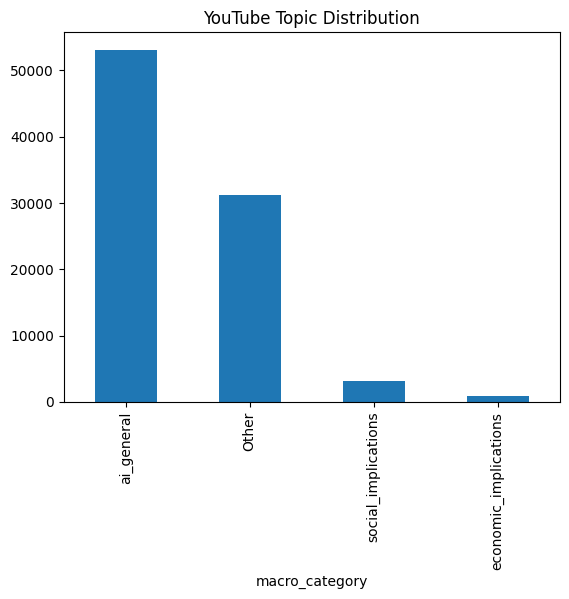

In [43]:
yt["macro_category"].value_counts().plot(kind="bar")
plt.title("YouTube Topic Distribution")
plt.show()

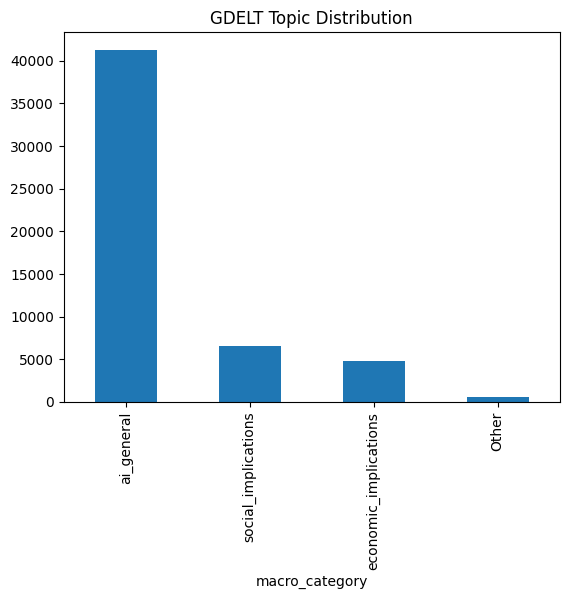

In [44]:
gd["macro_category"].value_counts().plot(kind="bar")
plt.title("GDELT Topic Distribution")
plt.show()

# Save processed datasets with macro category column

In [45]:
yt_topics_path = "../data/youtube_topics.csv"
gd_topics_path = "../data/gdelt_topics.csv"

yt.to_csv(yt_topics_path, index=False)
gd.to_csv(gd_topics_path, index=False)

yt_topics_path, gd_topics_path

('../data/youtube_topics.csv', '../data/gdelt_topics.csv')